In [1]:
#!pip install prince
#!pip install impyute
#!pip install autoimpute
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
#import prince
#import impyute
import inflect

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
sqf_cpw_filter = pd.read_csv('clean_sqf.csv')

In [9]:
p = inflect.engine()

sqf_cpw_filter['YEAR2'] = sqf_cpw_filter['YEAR2'].apply(lambda x: p.number_to_words(int(x)))
sqf_cpw_filter['MONTH2'] = sqf_cpw_filter['MONTH2'].apply(lambda x: p.number_to_words(int(x)))
sqf_cpw_filter['DAY2'] = sqf_cpw_filter['DAY2'].apply(lambda x: p.number_to_words(int(x)))
sqf_cpw_filter['STOP_LOCATION_PRECINCT'] = sqf_cpw_filter['STOP_LOCATION_PRECINCT'].apply(lambda x: p.number_to_words(int(x)))

In [10]:
# Convert to correct datatype --> object for categorical, float64 for numerical 
sqf_cpw_filter = sqf_cpw_filter.astype({'YEAR2': 'object',
                                        'STOP_LOCATION_PRECINCT': 'object',
                                        'LOCATION_IN_OUT_CODE': 'object', 'JURISDICTION_CODE': 'object',
                                        'OBSERVED_DURATION_MINUTES': 'float64', 
                                        'STOP_DURATION_MINUTES': 'float64',
                                        'OFFICER_IN_UNIFORM_FLAG': 'object', 'FRISKED_FLAG': 'object',
                                        'SUSPECT_SEX': 'object', 'SUSPECT_RACE_DESCRIPTION': 'object',
                                        'SUSPECT_REPORTED_AGE': 'float64', 'SUSPECT_BODY_BUILD_TYPE': 'object',
                                        'SUSPECT_WEIGHT': 'float64', 'WEAPON_FOUND_FLAG': 'object', 
                                        'MONTH2': 'string', 'DAY2': 'string',
                                        'STOP_FRISK_TIME': 'float64'
                                        })

In [11]:
sqf_cpw_filter = sqf_cpw_filter.drop(columns='FRISKED_FLAG')

In [12]:
sqf_cpw_filter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13031 entries, 0 to 13030
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   YEAR2                      13031 non-null  object 
 1   STOP_LOCATION_PRECINCT     13031 non-null  object 
 2   LOCATION_IN_OUT_CODE       10283 non-null  object 
 3   JURISDICTION_CODE          10735 non-null  object 
 4   OBSERVED_DURATION_MINUTES  13031 non-null  float64
 5   STOP_DURATION_MINUTES      13028 non-null  float64
 6   OFFICER_IN_UNIFORM_FLAG    13031 non-null  object 
 7   STOP_WAS_INITIATED         13031 non-null  object 
 8   SUSPECT_SEX                12998 non-null  object 
 9   SUSPECT_RACE_DESCRIPTION   13031 non-null  object 
 10  SUSPECT_REPORTED_AGE       12262 non-null  float64
 11  SUSPECT_WEIGHT             12720 non-null  float64
 12  SUSPECT_BODY_BUILD_TYPE    12882 non-null  object 
 13  WEAPON_FOUND_FLAG          13031 non-null  obj

### Impute

In [13]:
# simple imputation 

def fill_missing_data(df):
    num_cols = df.select_dtypes(['float64', 'int64'])
    cat_cols = df.select_dtypes(['object', 'string'])
    for col in num_cols:
        df[col] = df[col].fillna(df[col].mean())
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])    
    return df

In [14]:
sqf_cpw_filter_simpimp = fill_missing_data(sqf_cpw_filter)

In [12]:
# # imputation (ascending order of missing values) after ohe

# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# sqf_ohe = pd.get_dummies(sqf_cpw_filter, drop_first=True, columns=['YEAR2', 'STOP_LOCATION_PRECINCT', 
#                                                                    'LOCATION_IN_OUT_CODE', 
#                                                                    'OFFICER_IN_UNIFORM_FLAG', 'FRISKED_FLAG', 
#                                                                    'STOP_WAS_INITIATED', 'JURISDICTION_CODE', 
#                                                                    'SUSPECT_SEX', 'WEAPON_FOUND_FLAG', 
#                                                                    'SUSPECT_RACE_DESCRIPTION', 
#                                                                    'SUSPECT_BODY_BUILD_TYPE', 
#                                                                    'MONTH2', 'DAY2'])

# imputer = IterativeImputer(random_state=0)
# imputed = imputer.fit_transform(sqf_ohe)
# sqf_cpw_filter_itimp = pd.DataFrame(imputed, columns=sqf_ohe.columns)

# Predicting Frisk Processing

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [14]:
def standardize_data(df_num):
    train, test = train_test_split(df_num, test_size=0.2, random_state=1)
    train, val = train_test_split(train, test_size=0.25, random_state=1)
    scaler = StandardScaler()
    train_scale = scaler.fit_transform(train)
    val_scale = scaler.transform(val)
    test_scale = scaler.transform(test)
    scaled_train = pd.DataFrame(train_scale, index=train.index, columns=train.columns)
    scaled_val = pd.DataFrame(val_scale, index=val.index, columns=val.columns)
    scaled_test = pd.DataFrame(test_scale, index=test.index, columns=test.columns)
    return scaled_train, scaled_val, scaled_test

In [15]:
def process_data_simpleimputer(sqf_cpw, predict):
    weapon = 'WEAPON_FOUND_FLAG_Y'
    df_num = sqf_cpw.select_dtypes(['float64', 'int64'])
    df_cat = sqf_cpw.select_dtypes(['object', 'string'])
    cat = df_cat.columns
    df_ohe = pd.get_dummies(df_cat, prefix=cat, columns=cat, drop_first=True)
    train_cat, test_cat = train_test_split(df_ohe, test_size=0.2, random_state=1)
    train_cat, val_cat = train_test_split(train_cat, test_size=0.25, random_state=1)
    train_num, val_num, test_num = standardize_data(df_num)
    train = train_num.join(train_cat, how='outer')
    val = val_num.join(val_cat, how='outer')
    test = test_num.join(test_cat, how='outer')
    train_x = train.drop([weapon], axis=1)
    val_x = val.drop([weapon], axis=1)
    test_x = test.drop([weapon], axis=1)
    # targets
    targets_train = train[weapon]
    targets_val = val[weapon]
    targets_test = test[weapon]
    
    return train_x, val_x, test_x, targets_train, targets_val, targets_test

In [16]:
def process_data_itimputer(sqf_cpw, predict):
    # train, val, test split
    train, test = train_test_split(sqf_cpw, test_size=0.2, random_state=1)
    train, val = train_test_split(train, test_size=0.25, random_state=1)
#     # one hot encoding (or not)
#     if imputer == 'simple':
#         # combine for one hot encoding
#         combined = pd.concat([train, val, test], axis=0, sort=False)
#         num = combined.select_dtypes(['float64', 'int64']).columns
#         cat = combined.select_dtypes(['object', 'string']).columns
#         print(num)
#         print(cat)
#         combined = pd.get_dummies(combined, prefix=cat, columns=cat, drop_first=True)
#         #print(combined.shape)
#         train_index = train.shape[0]
#         val_index_1 = train.shape[0]
#         val_index_2 = val_index_1 + val.shape[0] - 1
#         test_index = val_index_2 + 1
#         df_train = combined.iloc[:train_index, :]
#         df_val = combined.iloc[val_index_1:val_index_2,:]
#         df_test = combined.iloc[test_index:,:]
#         weapon = 'WEAPON_FOUND_FLAG'
#     else:
    df_train = train
    df_val = val
    df_test = test
    weapon = 'WEAPON_FOUND_FLAG_Y'
    
    # standardize columns
    scaler = StandardScaler()
    train_scale = scaler.fit_transform(df_train)
    val_scale = scaler.transform(df_val)
    test_scale = scaler.transform(df_test)
    scaled_train = pd.DataFrame(train_scale, index=df_train.index, columns=df_train.columns)
    scaled_val = pd.DataFrame(val_scale, index=df_val.index, columns=df_val.columns)
    scaled_test = pd.DataFrame(test_scale, index=df_test.index, columns=df_test.columns)
    
    if predict == 'frisk':
        scaled_train_x = scaled_train.drop(['FRISKED_FLAG_Y', weapon], axis=1)
        scaled_val_x = scaled_val.drop(['FRISKED_FLAG_Y', weapon], axis=1)
        scaled_test_x = scaled_test.drop(['FRISKED_FLAG_Y', weapon], axis=1)
        # targets
        targets_train = df_train['FRISKED_FLAG_Y']
        targets_val = df_val['FRISKED_FLAG_Y']
        targets_test = df_test['FRISKED_FLAG_Y']
    else:
        scaled_train_x = scaled_train.drop([weapon], axis=1)
        scaled_val_x = scaled_val.drop([weapon], axis=1)
        scaled_test_x = scaled_test.drop([weapon], axis=1)
        # targets
        targets_train = df_train[weapon]
        targets_val = df_val[weapon]
        targets_test = df_test[weapon]
    
    return scaled_train_x, scaled_val_x, scaled_test_x, targets_train, targets_val, targets_test

# Predicting Frisk Simple Imputer

In [17]:
scaled_train, scaled_val, scaled_test, targets_train, targets_val, targets_test = process_data_simpleimputer(sqf_cpw_filter_simpimp, 'frisk')

Index(['YEAR2', 'STOP_LOCATION_PRECINCT', 'LOCATION_IN_OUT_CODE',
       'JURISDICTION_CODE', 'OFFICER_IN_UNIFORM_FLAG', 'FRISKED_FLAG',
       'STOP_WAS_INITIATED', 'SUSPECT_SEX', 'SUSPECT_RACE_DESCRIPTION',
       'SUSPECT_BODY_BUILD_TYPE', 'WEAPON_FOUND_FLAG', 'MONTH2', 'DAY2'],
      dtype='object')
(7818, 6)
Index(['OBSERVED_DURATION_MINUTES', 'STOP_DURATION_MINUTES',
       'SUSPECT_REPORTED_AGE', 'SUSPECT_WEIGHT', 'SUSPECT_HEIGHT',
       'STOP_FRISK_TIME', 'YEAR2_two thousand and fifteen',
       'YEAR2_two thousand and nineteen', 'YEAR2_two thousand and seventeen',
       'YEAR2_two thousand and sixteen',
       ...
       'MONTH2_ten', 'MONTH2_three', 'MONTH2_twelve', 'MONTH2_two',
       'DAY2_four', 'DAY2_one', 'DAY2_six', 'DAY2_three', 'DAY2_two',
       'DAY2_zero'],
      dtype='object', length=121)


In [18]:
scaled_train

,OBSERVED_DURATION_MINUTES,STOP_DURATION_MINUTES,SUSPECT_REPORTED_AGE,SUSPECT_WEIGHT,SUSPECT_HEIGHT,STOP_FRISK_TIME,YEAR2_two thousand and fifteen,YEAR2_two thousand and nineteen,YEAR2_two thousand and seventeen,YEAR2_two thousand and sixteen,...,MONTH2_ten,MONTH2_three,MONTH2_twelve,MONTH2_two,DAY2_four,DAY2_one,DAY2_six,DAY2_three,DAY2_two,DAY2_zero
9788,0.007903,-0.215211,-1.139877,-1.494227,-0.814166,0.730550,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4689,0.846662,-0.275626,-0.951511,0.007942,0.000420,-1.136151,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
606,-0.271683,-0.215211,2.815825,-0.045580,-0.767729,-0.996567,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3430,-0.271683,0.691009,-1.045694,-1.204498,-0.535541,-0.935150,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
9957,7.836318,0.328521,-0.198043,0.533878,0.300333,1.406135,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,0.287490,-0.215211,1.591441,-0.625039,-0.999916,-0.987261,1,0,0,0,...,0,1,0,0,0,1,0,0,0,0
9794,0.007903,-0.456870,-0.951511,-0.625039,0.300333,0.693327,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10189,-0.271683,-0.396455,-0.668960,0.823608,1.414832,1.301913,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4034,-0.271683,0.147277,0.084507,0.533878,0.021708,-0.721122,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(penalty='l2', max_iter=1000)

logreg.fit(scaled_train, targets_train)

y_train_pred = logreg.predict_proba(scaled_train)

In [20]:
from sklearn.metrics import roc_auc_score
print('The AUC score of my training set:')
roc_auc_score(targets_train, y_train_pred[:, 1])

The AUC score of my training set:


0.715072223639837

In [21]:
# AUC score for validation set
y_val_pred = logreg.predict_proba(scaled_val)
roc_auc_score(targets_val, y_val_pred[:, 1])

0.6345289276501658

In [83]:
# Accuracy
from sklearn.metrics import accuracy_score
y_acc_train = accuracy_score(targets_train, logreg.predict(scaled_train))
y_acc_val = accuracy_score(targets_val, logreg.predict(scaled_val))
print('acc train = ', y_acc_train)
print('acc val = ', y_acc_val)

acc train =  0.8956254796623178
acc val =  0.8937068303914044


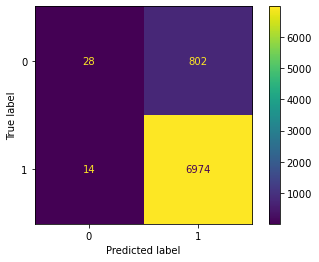

In [87]:
# Train conf matrix
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
#confusion_matrix(targets_train, logreg.predict(scaled_train))
plot_confusion_matrix(logreg, scaled_train, targets_train) 

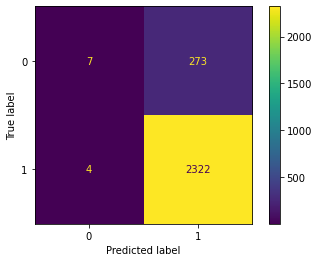

In [88]:
# Val conf matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logreg, scaled_val, targets_val) 

In [100]:
from sklearn.metrics import log_loss
ll = []

step = np.linspace(1, 1000, 112)

for i in step:
    logreg = LogisticRegression(penalty='l1', max_iter=i, solver='saga')
    logreg.fit(scaled_train, targets_train)
    loss = log_loss(targets_train, logreg.predict(scaled_train))
    #print(i, loss)
    ll.append(loss)

/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/eeshakhanna/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_

In [108]:
np.linspace(1, 1000, 112)

array([   1.,   10.,   19.,   28.,   37.,   46.,   55.,   64.,   73.,
         82.,   91.,  100.,  109.,  118.,  127.,  136.,  145.,  154.,
        163.,  172.,  181.,  190.,  199.,  208.,  217.,  226.,  235.,
        244.,  253.,  262.,  271.,  280.,  289.,  298.,  307.,  316.,
        325.,  334.,  343.,  352.,  361.,  370.,  379.,  388.,  397.,
        406.,  415.,  424.,  433.,  442.,  451.,  460.,  469.,  478.,
        487.,  496.,  505.,  514.,  523.,  532.,  541.,  550.,  559.,
        568.,  577.,  586.,  595.,  604.,  613.,  622.,  631.,  640.,
        649.,  658.,  667.,  676.,  685.,  694.,  703.,  712.,  721.,
        730.,  739.,  748.,  757.,  766.,  775.,  784.,  793.,  802.,
        811.,  820.,  829.,  838.,  847.,  856.,  865.,  874.,  883.,
        892.,  901.,  910.,  919.,  928.,  937.,  946.,  955.,  964.,
        973.,  982.,  991., 1000.])

In [101]:
ll

[3.6669030536765073,
 3.6669030536765073,
 3.6669030536765073,
 3.6580671427037927,
 3.6536491872174355,
 3.653649084940967,
 3.6492310271781414,
 3.644813071691784,
 3.640395116205427,
 3.627141249746355,
 3.627141147469887,
 3.6227231919835297,
 3.609469325524458,
 3.6006334145517433,
 3.591797503579029,
 3.6006332099988065,
 3.5962152545124493,
 3.5962152545124493,
 3.591797299026092,
 3.5873793435397348,
 3.5873793435397348,
 3.5873793435397348,
 3.5962150499595125,
 3.5962150499595125,
 3.5962150499595125,
 3.60505075637929,
 3.60505075637929,
 3.60505075637929,
 3.6094687118656474,
 3.60505075637929,
 3.60505075637929,
 3.60505075637929,
 3.6138864627990674,
 3.609468609589179,
 3.609468609589179,
 3.609468609589179,
 3.609468609589179,
 3.609468609589179,
 3.609468609589179,
 3.609468609589179,
 3.609468609589179,
 3.609468609589179,
 3.609468609589179,
 3.609468609589179,
 3.609468609589179,
 3.609468609589179,
 3.60946850731271,
 3.60946850731271,
 3.60946850731271,
 3.6094685

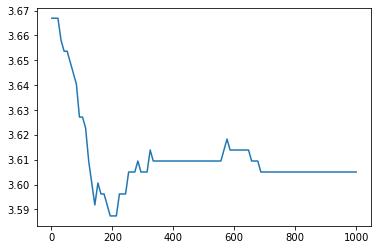

In [102]:
plt.plot(step, ll)

# Predicting Frisk Iterative Imputer

In [22]:
scaled_train_i, scaled_val_i, scaled_test_i, targets_train_i, targets_val_i, targets_test_i = process_data_itimputer(sqf_cpw_filter_itimp, 'frisk')

In [23]:
scaled_train_i.shape

(7818, 119)

In [24]:
logreg_i = LogisticRegression(penalty='l2', max_iter=1000)

logreg_i.fit(scaled_train_i, targets_train_i)

y_train_pred_i = logreg_i.predict_proba(scaled_train_i)

In [25]:
print('The AUC score of my training set:')
roc_auc_score(targets_train_i, y_train_pred_i[:, 1])

The AUC score of my training set:


0.7151615333687353

In [26]:
# AUC score for validation set
y_val_pred_i = logreg_i.predict_proba(scaled_val_i)
roc_auc_score(targets_val_i, y_val_pred_i[:, 1])

0.6329443557302543

# Predicting Found Weapon Simple Imputer

In [27]:
sqf_cpw_filter_weapon = sqf_cpw_filter_simpimp[sqf_cpw_filter_simpimp['FRISKED_FLAG'] == 'Y'] # we want to filter out only the found weapon after the suspect is frisked

In [28]:
scaled_train_w, scaled_val_w, scaled_test_w, targets_train_w, targets_val_w, targets_test_w = process_data_simpleimputer(sqf_cpw_filter_weapon, 'weapon')

Index(['YEAR2', 'STOP_LOCATION_PRECINCT', 'LOCATION_IN_OUT_CODE',
       'JURISDICTION_CODE', 'OFFICER_IN_UNIFORM_FLAG', 'FRISKED_FLAG',
       'STOP_WAS_INITIATED', 'SUSPECT_SEX', 'SUSPECT_RACE_DESCRIPTION',
       'SUSPECT_BODY_BUILD_TYPE', 'WEAPON_FOUND_FLAG', 'MONTH2', 'DAY2'],
      dtype='object')
(6984, 6)
Index(['OBSERVED_DURATION_MINUTES', 'STOP_DURATION_MINUTES',
       'SUSPECT_REPORTED_AGE', 'SUSPECT_WEIGHT', 'SUSPECT_HEIGHT',
       'STOP_FRISK_TIME', 'YEAR2_two thousand and fifteen',
       'YEAR2_two thousand and nineteen', 'YEAR2_two thousand and seventeen',
       'YEAR2_two thousand and sixteen',
       ...
       'MONTH2_ten', 'MONTH2_three', 'MONTH2_twelve', 'MONTH2_two',
       'DAY2_four', 'DAY2_one', 'DAY2_six', 'DAY2_three', 'DAY2_two',
       'DAY2_zero'],
      dtype='object', length=120)


In [29]:
targets_train_w

3975     0
7340     0
9814     0
7653     0
10669    0
        ..
5174     0
64       0
7603     0
2328     1
9181     0
Name: WEAPON_FOUND_FLAG_Y, Length: 6984, dtype: uint8

In [30]:
logreg_w = LogisticRegression(penalty='l2', max_iter=1000)

logreg_w.fit(scaled_train_w, targets_train_w)

y_train_pred_w = logreg_w.predict_proba(scaled_train_w)

In [31]:
print('The AUC score of my training set:')
roc_auc_score(targets_train_w, y_train_pred_w[:, 1])

The AUC score of my training set:


0.7176189123137514

In [32]:
# AUC score for validation set
y_val_pred_w = logreg_w.predict_proba(scaled_val_w)
roc_auc_score(targets_val_w, y_val_pred_w[:, 1])

0.6984038634914351

# Predicting Found Weapon Iterative Imputer

In [33]:
sqf_cpw_filter_weapon_it = sqf_cpw_filter_itimp[sqf_cpw_filter_itimp['FRISKED_FLAG_Y'] == 1] # we want to filter out only the found weapon after the suspect is frisked

In [34]:
scaled_train_w_i, scaled_val_w_i, scaled_test_w_i, targets_train_w_i, targets_val_w_i, targets_test_w_i = process_data_itimputer(sqf_cpw_filter_weapon_it, 'weapon')

In [35]:
logreg_w_i = LogisticRegression(penalty='l2', max_iter=1000)

logreg_w_i.fit(scaled_train_w_i, targets_train_w_i)

y_train_pred_w_i = logreg_w_i.predict_proba(scaled_train_w_i)

In [36]:
print('The AUC score of my training set:')
roc_auc_score(targets_train_w_i, y_train_pred_w_i[:, 1])

The AUC score of my training set:


0.7188713705819225

In [37]:
# AUC score for validation set
y_val_pred_w_i = logreg_w_i.predict_proba(scaled_val_w_i)
roc_auc_score(targets_val_w_i, y_val_pred_w_i[:, 1])

0.6955755106977154

# Hyperparam Selection - Predicting Weapon Simple Imputer

In [38]:
# Lasso
#creating 30 values for C between 1e-2 and 10 
import numpy as np

C_list_train_log = []
C_range_log = []
for i in np.logspace(-2,1,num=30):
  C_range_log.append(i)

#creating 20 instances of logistic regression for the 20 values of C
for C_in_range in C_range_log:  
  clf_l1_C_in_range = LogisticRegression(C=C_in_range, penalty='l1', solver='liblinear').fit(scaled_train_w, targets_train_w)
  C_list_train_log.append(clf_l1_C_in_range)

In [39]:
predicted_values_train = []
predicted_values_val = []
predicted_values_test = []
for classifier in C_list_train_log:
  pred_train = classifier.predict_proba(scaled_train_w)
  pred_val = classifier.predict_proba(scaled_val_w)
  pred_test = classifier.predict_proba(scaled_test_w)
  predicted_values_train.append(pred_train)
  predicted_values_val.append(pred_val)
  predicted_values_test.append(pred_test)

In [40]:
len(predicted_values_test)

30

In [41]:
# checking AUC score on training predictions with l1 regularization
from sklearn import metrics 
auc_train = []
for pred in predicted_values_train:
  auc_list = metrics.roc_auc_score(y_true=targets_train_w, y_score=pred[:,1])
  auc_train.append(auc_list)
auc_train

[0.6495636084580086,
 0.6561817846896411,
 0.6596396553614298,
 0.6639659090315859,
 0.6699288453951612,
 0.6732675408667275,
 0.6757486671096583,
 0.6792943157605846,
 0.68406535096649,
 0.6877685077668969,
 0.6930915672732074,
 0.6979123458198814,
 0.7010675800946092,
 0.7037335845111019,
 0.7063684154396767,
 0.709038894519507,
 0.7112851755149405,
 0.7128486228850691,
 0.71416029586474,
 0.7151717189344633,
 0.7159756667807706,
 0.7166851992306562,
 0.7173492392699438,
 0.7178205704748288,
 0.7181038166640936,
 0.7183281464527478,
 0.7184541828034213,
 0.7185635137443013,
 0.7186097519321223,
 0.7186756786386284]

In [42]:
# checking AUC score on validation predictions with l1 regularization
auc_val = []
for pred in predicted_values_val:
  auc_list = metrics.roc_auc_score(y_true=targets_val_w, y_score=pred[:,1])
  auc_val.append(auc_list)
auc_val

[0.6591910471227214,
 0.6669119829804077,
 0.6696070266288454,
 0.6753633704949755,
 0.6823064406183346,
 0.6866671614222575,
 0.6884750808100798,
 0.6912017338434813,
 0.6937167414297338,
 0.6954724366163115,
 0.6970151120346549,
 0.7000393055830421,
 0.7017846933614794,
 0.7021392682015084,
 0.7035836796622468,
 0.7043876574971963,
 0.7040482001891066,
 0.7030710578973988,
 0.7023110583371814,
 0.7016293950788312,
 0.7011250192404951,
 0.7010082019482375,
 0.7004392330188887,
 0.699802922356356,
 0.6989453459990764,
 0.698353013611276,
 0.6977991622138663,
 0.6973744969984826,
 0.6969690722782944,
 0.6966227433647778]

In [44]:
predicted_values_test[0][:,1].shape

(2328,)

In [45]:
# checking AUC score on test predictions with l1 regularization
auc_test = []
for pred in predicted_values_test:
  auc_list = metrics.roc_auc_score(y_true=targets_test_w, y_score=pred[:,1])
  auc_test.append(auc_list)
auc_test

[0.667694659321769,
 0.6751427224957024,
 0.6789946427176122,
 0.6827940645022661,
 0.6869768469682763,
 0.6885127314814814,
 0.689095708313799,
 0.6900449533130177,
 0.6904759288560712,
 0.6906395286372871,
 0.6937399886701047,
 0.6983610720425066,
 0.7012545905610252,
 0.7035327785591499,
 0.705154125644632,
 0.7052969702297234,
 0.7051980778246602,
 0.7050674421784653,
 0.7048806454133458,
 0.7046535591498673,
 0.7038782915299265,
 0.70290279731208,
 0.701877246444757,
 0.7010482594936709,
 0.7004671140021879,
 0.6999286997968432,
 0.6994415631348647,
 0.6991058173152055,
 0.6988201281450226,
 0.6986235642287857]

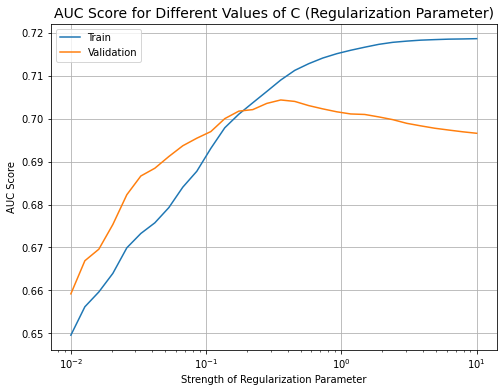

In [46]:
#plotting regularization strength vs. AUC score for train, val, and test
plt.figure(figsize=(8, 6))
plt.semilogx(C_range_log, auc_train, label='Train')
plt.semilogx(C_range_log, auc_val, label='Validation')
#plt.semilogx(C_range_log, auc_test, label='Test')
plt.xlabel("Strength of Regularization Parameter")
plt.ylabel("AUC Score")
plt.title("AUC Score for Different Values of C (Regularization Parameter)", size=14)
plt.grid()
plt.legend()
plt.show()

In [47]:
# Choose C hyperparam where validation performs best

# DIMENSIONALITY REDUCTION

### FAMD

In [48]:
# sqf_dr = sqf_cpw_filter_simpimp[['LOCATION_IN_OUT_CODE', 'OBSERVED_DURATION_MINUTES',
#                                 'JURISDICTION_CODE', 'STOP_DURATION_MINUTES', 'OFFICER_IN_UNIFORM_FLAG',
#                                 'STOP_WAS_INITIATED', 'SUSPECT_SEX', 'SUSPECT_RACE_DESCRIPTION',
#                                 'SUSPECT_REPORTED_AGE', 'SUSPECT_WEIGHT', 'SUSPECT_BODY_BUILD_TYPE',
#                                 'SUSPECT_HEIGHT', 'STOP_FRISK_TIME', 'MONTH2']]

In [49]:
sqf_cpw_filter_simpimp = sqf_cpw_filter_simpimp.astype({'YEAR2': 'object'})

In [50]:
sqf_dr = sqf_cpw_filter_simpimp.drop(columns=['FRISKED_FLAG', 'WEAPON_FOUND_FLAG'])
sqf_dr_num = sqf_dr.select_dtypes(['float64', 'int64'])
sqf_dr_cat = sqf_dr.select_dtypes(['object', 'string'])

scaler_famd = StandardScaler()
train_dr_num = scaler_famd.fit_transform(sqf_dr_num)
train_dr_num_df = pd.DataFrame(train_dr_num, index=sqf_dr_num.index, columns=sqf_dr_num.columns)
sqf_dr = pd.merge(train_dr_num_df, sqf_dr_cat, left_index=True, right_index=True)

In [51]:
sqf_famd = sqf_dr[['LOCATION_IN_OUT_CODE', 'OBSERVED_DURATION_MINUTES',
                                'JURISDICTION_CODE', 'STOP_DURATION_MINUTES', 'OFFICER_IN_UNIFORM_FLAG',
                                'STOP_WAS_INITIATED', 'SUSPECT_SEX', 'SUSPECT_RACE_DESCRIPTION',
                                'SUSPECT_REPORTED_AGE', 'SUSPECT_WEIGHT', 'SUSPECT_BODY_BUILD_TYPE',
                                'SUSPECT_HEIGHT', 'STOP_FRISK_TIME']]

In [52]:
from prince import FAMD
famd = FAMD(n_components = 20, random_state = 101)

famd.fit(sqf_famd)
famd.transform(sqf_famd)
famd.explained_inertia_

array([0.11928708, 0.08575533, 0.07991801, 0.07355764, 0.06636375,
       0.06177326, 0.05712362, 0.05062703, 0.04236867, 0.03892719,
       0.03606277, 0.03391645, 0.03229201, 0.03185776, 0.03018125,
       0.02988059, 0.02905831, 0.0286271 , 0.02722835, 0.02448693])

In [53]:
famd.explained_inertia_.sum()

0.9792930808753596

### PCA

In [54]:
# OHE

sqf_ohe = pd.get_dummies(sqf_cpw_filter_simpimp, drop_first=True, columns=['YEAR2', 'STOP_LOCATION_PRECINCT', 
                                                                   'LOCATION_IN_OUT_CODE', 
                                                                   'OFFICER_IN_UNIFORM_FLAG', 'FRISKED_FLAG', 
                                                                   'STOP_WAS_INITIATED', 'JURISDICTION_CODE', 
                                                                   'SUSPECT_SEX', 'WEAPON_FOUND_FLAG', 
                                                                   'SUSPECT_RACE_DESCRIPTION', 
                                                                   'SUSPECT_BODY_BUILD_TYPE', 
                                                                   'MONTH2', 'DAY2'])

In [55]:
# imputation (ascending order of missing values)

# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer

# imputer = IterativeImputer(random_state=0)
# imputed = imputer.fit_transform(sqf_ohe)
# df_imputed = pd.DataFrame(imputed, columns=sqf_ohe.columns)

In [56]:
df_imputed_dr = sqf_ohe

In [57]:
from sklearn.model_selection import train_test_split

train_dr, test_dr = train_test_split(df_imputed_dr, test_size=0.2, random_state=1)

train_dr, val_dr = train_test_split(train_dr, test_size=0.25, random_state=1)

In [58]:
train_targets_pca = train_dr['FRISKED_FLAG_Y']
train_dr = train_dr.drop(columns='FRISKED_FLAG_Y')
val_targets_pca = val_dr['FRISKED_FLAG_Y']
val_dr = val_dr.drop(columns='FRISKED_FLAG_Y')
test_targets_pca = test_dr['FRISKED_FLAG_Y']
test_dr = test_dr.drop(columns='FRISKED_FLAG_Y')

In [59]:
from sklearn.preprocessing import StandardScaler

scaler_pca = StandardScaler()
train_pca = scaler_pca.fit_transform(train_dr)
train_pca_df = pd.DataFrame(train_pca, index=train_dr.index, columns=train_dr.columns)
val_pca = scaler_pca.transform(val_dr)
val_pca_df = pd.DataFrame(val_pca, index=val_dr.index, columns=val_dr.columns)
test_pca = scaler_pca.transform(test_dr)
test_pca_df = pd.DataFrame(test_pca, index=test_dr.index, columns=test_dr.columns)

In [60]:
train_pca_df.shape

(7818, 120)

In [61]:
from sklearn.decomposition import PCA

n_components = np.linspace(1, train_pca_df.shape[1], train_pca_df.shape[1], dtype=int)
explained_variance_marginal = []
explained_variance_cumulative = []

for i in n_components:
  pca = PCA(n_components=i)
  pca.fit(train_pca_df)
  explained_variance_marginal.append(pca.explained_variance_ratio_[i-1])
  explained_variance_cumulative.append(np.sum(pca.explained_variance_ratio_))

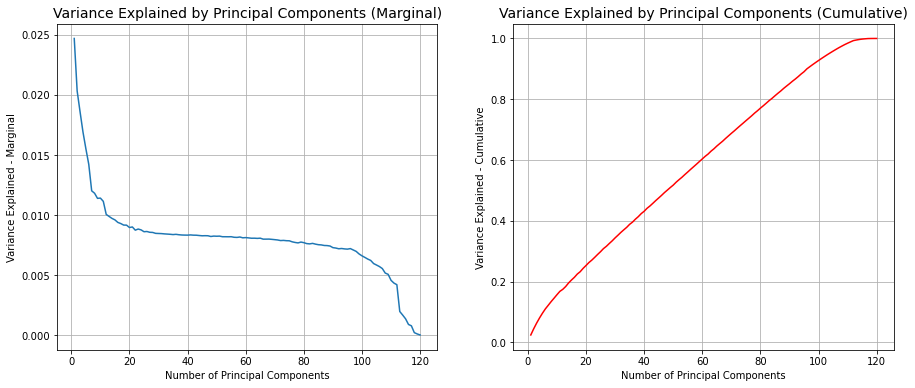

In [62]:
# figure for report
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].plot(n_components, explained_variance_marginal)
#axes[0].scatter(n_components, explained_variance_marginal)
axes[0].set_xlabel("Number of Principal Components")
axes[0].set_ylabel("Variance Explained - Marginal")
axes[0].set_title("Variance Explained by Principal Components (Marginal)", size=14)
axes[0].grid()

#axes[1].scatter(n_components, explained_variance_cumulative, color='red')
axes[1].plot(n_components, explained_variance_cumulative, color='red')
axes[1].set_xlabel("Number of Principal Components")
axes[1].set_ylabel("Variance Explained - Cumulative")
axes[1].set_title("Variance Explained by Principal Components (Cumulative)", size=14)
axes[1].grid()

In [63]:
n_comp = 90

In [64]:
# train pca
pca = PCA(n_components=n_comp)
pca_train_data = pca.fit_transform(train_pca_df)
pca.explained_variance_ratio_.sum()

0.8516446465478101

In [65]:
# val pca
pca_val_data = pca.transform(val_pca_df)

In [66]:
# test pca
pca_test_data = pca.transform(test_pca_df)

In [67]:
cols = np.linspace(1, n_comp, 90, dtype=int)
pca_train_data_df = pd.DataFrame(data = pca_train_data, columns=cols, index=train_pca_df.index)
pca_val_data_df = pd.DataFrame(data = pca_val_data, columns=cols, index=val_pca_df.index)
pca_test_data_df = pd.DataFrame(data = pca_test_data, columns=cols, index=test_pca_df.index)

In [68]:
pca_train_data_df

,1,2,3,4,5,6,7,8,9,10,...,81,82,83,84,85,86,87,88,89,90
9788,-0.877722,0.701669,-2.373210,-0.318890,0.924593,-0.215780,1.494004,0.113207,0.386991,-0.815593,...,-0.932205,0.244337,1.008629,1.168532,0.239080,-0.021355,-0.136028,-0.271826,0.508893,-0.935239
4689,-0.599644,-1.043546,-0.512187,-1.817138,1.503905,-0.482509,-2.389607,0.100669,-0.450648,-0.543399,...,0.236668,0.157176,2.225785,-1.339017,0.451801,-0.022471,-0.706598,-0.616914,1.450791,-1.024413
606,-0.577328,-1.453399,3.308285,-1.310959,1.609205,-1.332767,0.856375,0.588939,0.088185,-0.367480,...,0.738006,1.086876,-1.844422,-1.180252,-1.035052,1.268832,-0.142638,-0.582271,-1.024587,0.225339
3430,-0.453356,1.300107,-0.080650,-0.804677,0.855590,2.867112,0.740307,0.605202,2.474055,0.277049,...,0.158250,0.390905,0.796493,-0.257921,1.045873,0.078038,-0.650096,-0.361819,0.137806,-0.273457
9957,-0.090787,0.317778,-0.796296,2.832912,-0.876554,-0.597788,-0.379632,1.311252,0.197554,-0.923432,...,1.208186,0.573648,-0.516711,0.794704,-1.159985,2.474268,-0.414873,0.046118,1.341231,1.482122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,0.720859,1.225139,0.708605,-3.248945,-0.940651,-0.556204,0.508873,-1.400606,-0.129056,-0.169739,...,-0.747951,-1.123049,-0.503342,0.632312,-1.100545,1.144033,-2.204627,-0.230863,-0.729123,-0.072412
9794,-0.921106,0.800033,-1.793316,0.023304,0.838891,0.092380,0.938094,-0.692154,0.773398,-0.417250,...,-0.864795,0.098628,0.883986,0.719961,-0.312533,0.025536,-0.320337,-0.723347,0.511072,-0.540470
10189,-0.928365,0.064577,0.393432,1.264929,0.918514,-2.148756,1.432457,-0.395539,1.194871,-0.245396,...,0.067492,0.755275,-1.102690,-0.689267,-1.089510,0.112751,0.622422,0.898882,0.626362,-0.374219
4034,0.085889,-2.868541,0.148334,-0.803243,-0.082360,-0.626974,-2.443424,1.356737,0.130485,-0.649704,...,0.101081,0.418767,-0.270233,0.741918,-0.272809,-0.352912,-0.494070,-0.664341,-1.011239,1.102381


In [69]:
from sklearn.linear_model import LogisticRegression

logreg_pca = LogisticRegression(penalty='l2', max_iter=1000)

logreg_pca.fit(pca_train_data_df, train_targets_pca)

y_train_pred_pca = logreg_pca.predict_proba(pca_train_data_df)

In [70]:
from sklearn.metrics import roc_auc_score
print('The AUC score of my training set:')
roc_auc_score(train_targets_pca, y_train_pred_pca[:, 1])

The AUC score of my training set:


0.6979957896842091

In [71]:
# AUC score for validation set
y_val_pred_pca = logreg_pca.predict_proba(pca_val_data)
roc_auc_score(val_targets_pca, y_val_pred_pca[:, 1])

0.6154265446505344

In [72]:
comp_matrix = pca.components_[0:90, :]

In [73]:
comp_matrix.shape

(90, 120)

In [ ]:
# # Convert component matrix to df for easy interpretation
# comp_matrix_df = pd.DataFrame(comp_matrix, columns=cols, index=np.linspace(0, 120, 120))